# Credit Card Reviews and Benefits Analysis

This notebook analyzes credit card reviews and features by merging the datasets, performing EDA, and applying machine learning models. Key steps include:
- Data Merging
- Exploratory Data Analysis (EDA)
- Sentiment Analysis using BERT
- Card Recommendation using Random Forest
- Static Visualizations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
from imblearn.over_sampling import SMOTE

## Step 1: Load and Merge Datasets

Merge the reviews dataset with the credit data based on matching card names.

In [ ]:
reviews_path = 'credit_card_reviews_28.csv'
credit_data_path = 'credit-data-test.csv'
reviews_df = pd.read_csv(reviews_path)
credit_data_df = pd.read_csv(credit_data_path, encoding='latin1')

In [ ]:
# Normalize card names for merging
reviews_df['card_name'] = reviews_df['card_name'].str.lower().str.strip()
credit_data_df['Card Name'] = credit_data_df['Card Name'].str.lower().str.strip()

In [ ]:
# Define a function to normalize card names
import re

def normalize_card_name(name):
    if isinstance(name, str):
        name = re.sub(r'[^\w\s]', '', name)  # Remove special characters
        name = re.sub(r'\b(annual fee|min security deposit)\b', '', name, flags=re.IGNORECASE)
        name = name.lower().strip()
        return name
    return name

In [ ]:
# Normalize card names in both datasets
reviews_df['normalized_card_name'] = reviews_df['card_name'].apply(normalize_card_name)
credit_data_df['normalized_card_name'] = credit_data_df['Card Name'].apply(normalize_card_name)

In [ ]:
# Merge the datasets
merged_df = pd.merge(reviews_df, credit_data_df, on='normalized_card_name', how='inner')

In [ ]:
# Check the merged dataset
print(f"Merged dataset contains {merged_df.shape[0]} rows.")
display(merged_df.head())

Merged dataset contains 42 rows.


,card_name,review,normalized_card_name,Card Name,Transfer Intro APR,Regular APR,Annual Fee,Rewards Rate,Bonus Offer,Accepted Credit,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,wells fargo active cash annual fee,The Wells Fargo Active Cash® Card is one of th...,wells fargo active cash,wells fargo active cash®,0% for 12 months,19.49%-29.49% Variable,$0,2% Cash Back,"$200 Bonus (spending $1,000 in 3 months)","Excellent, Good",NaN,NaN,NaN
1,wells fargo active cash annual fee,Wells Fargo Active Cash Credit Card is NOT sec...,wells fargo active cash,wells fargo active cash®,0% for 12 months,19.49%-29.49% Variable,$0,2% Cash Back,"$200 Bonus (spending $1,000 in 3 months)","Excellent, Good",NaN,NaN,NaN
2,wells fargo active cash annual fee,"Sure, use this card for groceries and disposab...",wells fargo active cash,wells fargo active cash®,0% for 12 months,19.49%-29.49% Variable,$0,2% Cash Back,"$200 Bonus (spending $1,000 in 3 months)","Excellent, Good",NaN,NaN,NaN
3,wells fargo active cash annual fee,"The card is great, but they never offer a cred...",wells fargo active cash,wells fargo active cash®,0% for 12 months,19.49%-29.49% Variable,$0,2% Cash Back,"$200 Bonus (spending $1,000 in 3 months)","Excellent, Good",NaN,NaN,NaN
4,wells fargo active cash annual fee,"Good card, horrible website. Ridiculously hard...",wells fargo active cash,wells fargo active cash®,0% for 12 months,19.49%-29.49% Variable,$0,2% Cash Back,"$200 Bonus (spending $1,000 in 3 months)","Excellent, Good",NaN,NaN,NaN


In [ ]:
display(merged_df)

,card_name,review,normalized_card_name,Card Name,Transfer Intro APR,Regular APR,Annual Fee,Rewards Rate,Bonus Offer,Accepted Credit,Unnamed: 7,Unnamed: 8,Unnamed: 9,truncated_review,predicted_sentiment,sentiment_numeric,Accepted Credit Numeric,review_length,recommendation_score
0,wells fargo active cash annual fee,The Wells Fargo Active Cash® Card is one of th...,wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,the wells fargo active cash® card is one of th...,positive,1,1,4093,0.90
1,wells fargo active cash annual fee,Wells Fargo Active Cash Credit Card is NOT sec...,wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,wells fargo active cash credit card is not sec...,negative,0,1,419,0.06
2,wells fargo active cash annual fee,"Sure, use this card for groceries and disposab...",wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,"sure, use this card for groceries and disposab...",positive,1,1,428,0.70
3,wells fargo active cash annual fee,"The card is great, but they never offer a cred...",wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,"the card is great, but they never offer a cred...",negative,0,1,374,0.17
4,wells fargo active cash annual fee,"Good card, horrible website. Ridiculously hard...",wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,"good card, horrible website. ridiculously hard...",negative,0,1,186,0.15
5,wells fargo active cash annual fee,If I had read the reviews before I signed up f...,wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,if i had read the reviews before i signed up f...,negative,0,1,689,0.02
6,wells fargo active cash annual fee,"I have a credit score of 817, substantial asse...",wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,"i have a credit score of 817, substantial asse...",positive,1,1,297,0.87
7,wells fargo active cash annual fee,I have been a Wells Fargo customer for over 15...,wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,i have been a wells fargo customer for over 15...,positive,1,1,1323,0.91
8,wells fargo active cash annual fee,I applied for this card with a credit score of...,wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,i applied for this card with a credit score of...,negative,0,1,1138,0.06
9,wells fargo active cash annual fee,I agree with the benefits of the Costco Citi V...,wells fargo active cash,wells fargo active cash®,0.0,24.49,$0,2.0,200.0,"Excellent, Good",NaN,NaN,NaN,i agree with the benefits of the costco citi v...,negative,0,1,482,0.00


In [ ]:
# Clean Rewards Rate
merged_df['Rewards Rate'] = merged_df['Rewards Rate'].apply(
    lambda x: float(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 0
)

# Clean Bonus Offer
merged_df['Bonus Offer'] = merged_df['Bonus Offer'].apply(
    lambda x: float(re.search(r'\d+', str(x)).group()) if re.search(r'\d+', str(x)) else 0
)

# Clean Transfer Intro APR
def extract_apr(apr):
    if isinstance(apr, str):
        match = re.search(r'(\d+\.?\d*)', apr)
        if match:
            return float(match.group())
    return 0

merged_df['Transfer Intro APR'] = merged_df['Transfer Intro APR'].apply(extract_apr)

# Clean Regular APR
def average_apr(apr):
    if isinstance(apr, str):
        match = re.findall(r'(\d+\.?\d*)', apr)
        if match:
            return np.mean([float(num) for num in match])
    return 0

merged_df['Regular APR'] = merged_df['Regular APR'].apply(average_apr)

# Verify the cleaned features
print(merged_df[['Rewards Rate', 'Bonus Offer', 'Transfer Intro APR', 'Regular APR']].head())

   Rewards Rate  Bonus Offer  Transfer Intro APR  Regular APR
0           2.0        200.0                 0.0        24.49
1           2.0        200.0                 0.0        24.49
2           2.0        200.0                 0.0        24.49
3           2.0        200.0                 0.0        24.49
4           2.0        200.0                 0.0        24.49


In [ ]:
# Check unique values for each column
print("Unique values in Rewards Rate:", merged_df['Rewards Rate'].unique())
print("Unique values in Bonus Offer:", merged_df['Bonus Offer'].unique())
print("Unique values in Transfer Intro APR:", merged_df['Transfer Intro APR'].unique())
print("Unique values in Regular APR:", merged_df['Regular APR'].unique())

Unique values in Rewards Rate: [2. 5.]
Unique values in Bonus Offer: [200.   1.]
Unique values in Transfer Intro APR: [0.]
Unique values in Regular APR: [24.49 22.99]


In [ ]:
# # Prepare updated feature set
# X = merged_df[['Rewards Rate', 'Bonus Offer', 'Regular APR', 'review_length']].fillna(0)
# y = merged_df['sentiment_numeric']

## Step 2: Exploratory Data Analysis (EDA)

Analyze the merged dataset to understand feature distributions, review lengths, and sentiment proportions.

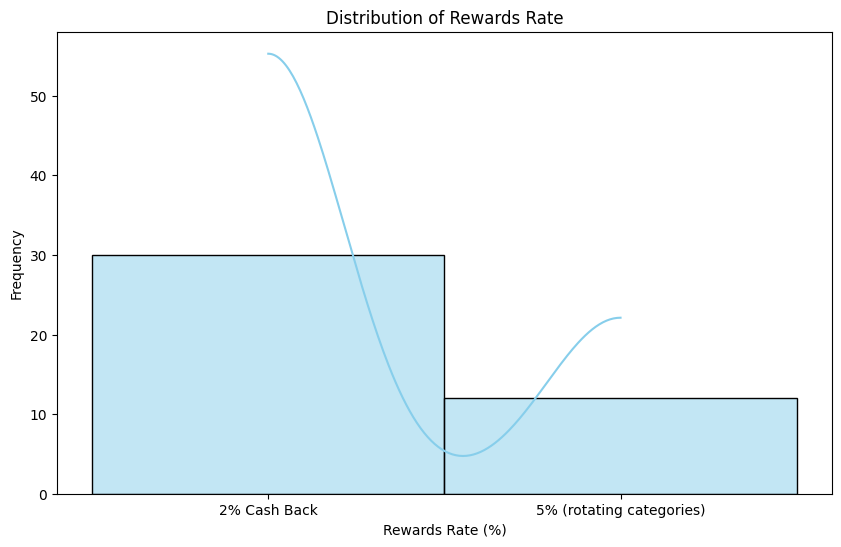

In [ ]:
# Analyze feature distributions
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Rewards Rate'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Rewards Rate')
plt.xlabel('Rewards Rate (%)')
plt.ylabel('Frequency')
plt.show()

## Step 3: Sentiment Analysis using BERT

Use BERT to predict the sentiment of each review in the merged dataset.

In [ ]:
# Load BERT pipeline
from transformers import AutoTokenizer

In [ ]:
# Truncate reviews for BERT input limit
max_token_length = 512
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def truncate_review(review, tokenizer, max_length=max_token_length):
    tokens = tokenizer.tokenize(review)
    truncated_tokens = tokens[:max_length]
    return tokenizer.convert_tokens_to_string(truncated_tokens)

merged_df['truncated_review'] = merged_df['review'].apply(
    lambda review: truncate_review(review, tokenizer, max_token_length)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (892 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Load fine-tuned sentiment analysis model
sentiment_analyzer = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# Predict sentiments
merged_df['predicted_sentiment'] = merged_df['truncated_review'].apply(
    lambda review: sentiment_analyzer(review, truncation=True, max_length=512)[0]['label'].lower()
)

In [ ]:
# Updated mapping function to handle multiple values
def map_accepted_credit(credit):
    if isinstance(credit, str):
        credit_scores = [credit_mapping.get(c.strip(), 0) for c in credit.split(',')]  # Map each value
        return max(credit_scores)  # Return the highest score
    return 0  # Default to 0 if not a string

# Apply the updated mapping function
merged_df['Accepted Credit Numeric'] = merged_df['Accepted Credit'].apply(map_accepted_credit)

# Verify the column
print(merged_df[['Accepted Credit', 'Accepted Credit Numeric']].head())

   Accepted Credit  Accepted Credit Numeric
0  Excellent, Good                        1
1  Excellent, Good                        1
2  Excellent, Good                        1
3  Excellent, Good                        1
4  Excellent, Good                        1


In [ ]:
# Map sentiment labels to numeric values
merged_df['sentiment_numeric'] = merged_df['predicted_sentiment'].map({'positive': 1, 'negative': 0})

Updated Sentiment Distribution:
predicted_sentiment
negative    25
positive    17
Name: count, dtype: int64


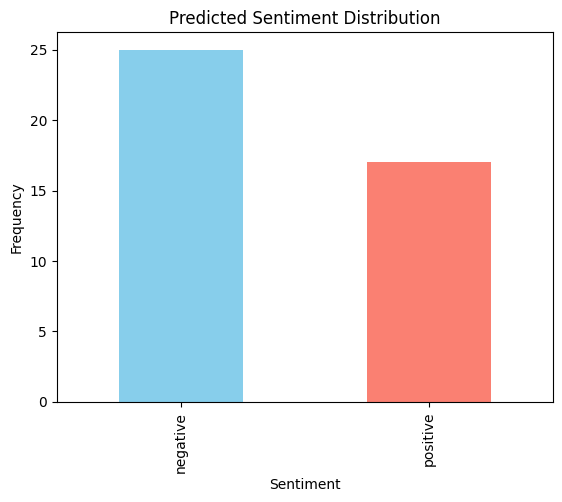

In [ ]:
# Sentiment Distribution
print("Updated Sentiment Distribution:")
print(merged_df['predicted_sentiment'].value_counts())
sentiment_counts = merged_df['predicted_sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Predicted Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

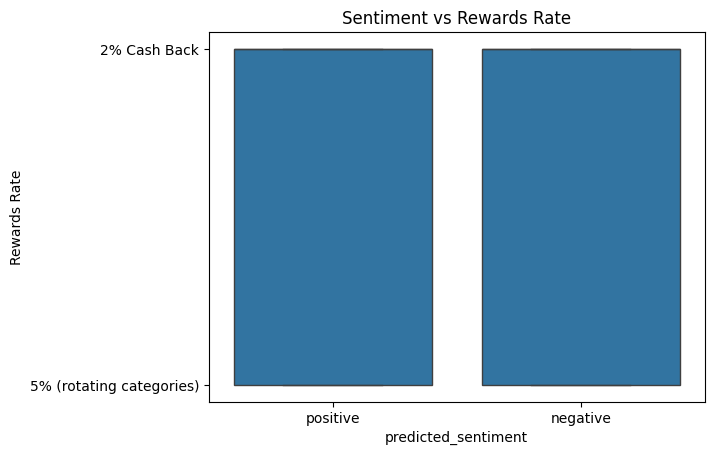

In [ ]:
# Rewards Rate vs Sentiment
sns.boxplot(x='predicted_sentiment', y='Rewards Rate', data=merged_df)
plt.title('Sentiment vs Rewards Rate')
plt.show()

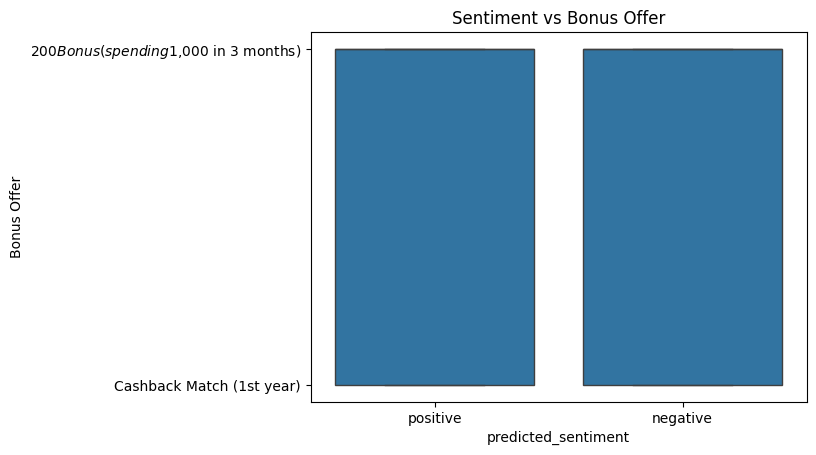

In [ ]:
# Bonus Offer vs Sentiment
sns.boxplot(x='predicted_sentiment', y='Bonus Offer', data=merged_df)
plt.title('Sentiment vs Bonus Offer')
plt.show()

In [ ]:
print(merged_df.columns)

Index(['card_name', 'review', 'normalized_card_name', 'Card Name',
       'Transfer Intro APR', 'Regular APR', 'Annual Fee', 'Rewards Rate',
       'Bonus Offer', 'Accepted Credit', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'truncated_review', 'predicted_sentiment',
       'sentiment_numeric'],
      dtype='object')


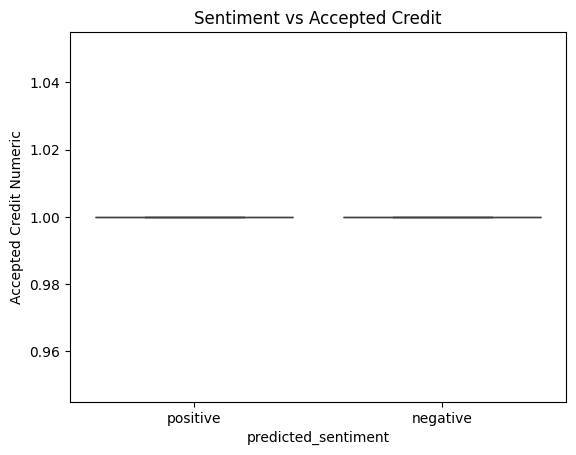

In [ ]:
# Accepted Credit vs Sentiment
sns.boxplot(x='predicted_sentiment', y='Accepted Credit Numeric', data=merged_df)
plt.title('Sentiment vs Accepted Credit')
plt.show()

## Step 4: Random Forest for Recommendations

Train a Random Forest model to predict recommendation scores using credit card features.

In [ ]:
# Add review length as a feature
merged_df['review_length'] = merged_df['review'].apply(len)

# Verify the column
print(merged_df[['review', 'review_length']].head())

                                              review  review_length
0  The Wells Fargo Active Cash® Card is one of th...           4093
1  Wells Fargo Active Cash Credit Card is NOT sec...            419
2  Sure, use this card for groceries and disposab...            428
3  The card is great, but they never offer a cred...            374
4  Good card, horrible website. Ridiculously hard...            186


In [ ]:
# Define features (X) and target (y)
X = merged_df[['Rewards Rate', 'Bonus Offer', 'Regular APR', 'review_length']].fillna(0)
y = merged_df['sentiment_numeric']  # Target

# Verify the dimensions
print("Feature set dimensions:", X.shape)
print("Target dimensions:", y.shape)

Feature set dimensions: (42, 4)
Target dimensions: (42,)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Generate recommendation scores
merged_df['recommendation_score'] = rf_model.predict_proba(X)[:, 1]

# Display top recommended cards
top_recommendations = merged_df.nlargest(5, 'recommendation_score')
print("Top Recommended Cards:")
display(top_recommendations[['card_name', 'Rewards Rate', 'Bonus Offer', 'Regular APR', 'recommendation_score']])

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89         9

Top Recommended Cards:


,card_name,Rewards Rate,Bonus Offer,Regular APR,recommendation_score
0,wells fargo active cash annual fee,2.0,200.0,24.49,0.99
27,wells fargo active cash annual fee,2.0,200.0,24.49,0.99
13,wells fargo active cash annual fee,2.0,200.0,24.49,0.98
40,wells fargo active cash annual fee,2.0,200.0,24.49,0.98
6,wells fargo active cash annual fee,2.0,200.0,24.49,0.97


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.80      0.89         5

    accuracy                           0.89         9
   macro avg       0.90      0.90      0.89         9
weighted avg       0.91      0.89      0.89         9



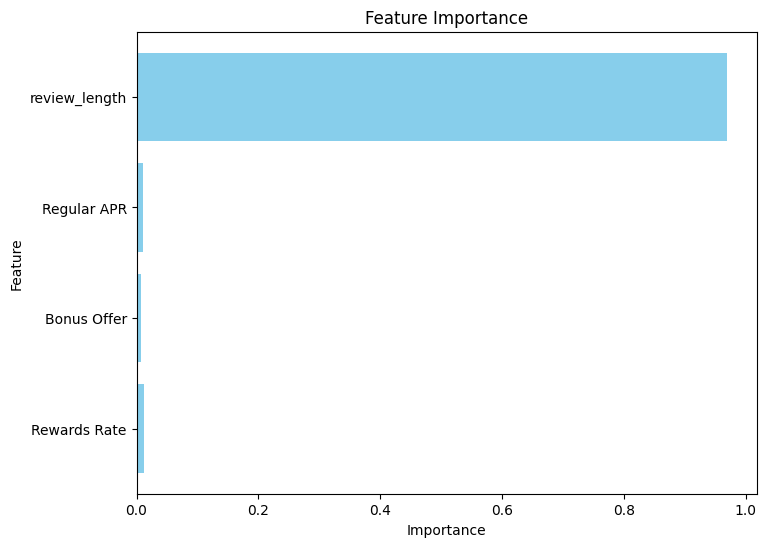

In [ ]:
# Classification Report
y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Generate recommendation scores
merged_df['recommendation_score'] = rf_model.predict_proba(X)[:, 1]

# Display top recommended cards
top_recommendations = merged_df.nlargest(5, 'recommendation_score')
print("Top Recommended Cards:")
display(top_recommendations[['card_name', 'Rewards Rate', 'Bonus Offer', 'Regular APR', 'review_length', 'recommendation_score']])

Top Recommended Cards:


,card_name,Rewards Rate,Bonus Offer,Regular APR,review_length,recommendation_score
0,wells fargo active cash annual fee,2.0,200.0,24.49,4093,0.99
27,wells fargo active cash annual fee,2.0,200.0,24.49,4093,0.99
13,wells fargo active cash annual fee,2.0,200.0,24.49,246,0.98
40,wells fargo active cash annual fee,2.0,200.0,24.49,246,0.98
6,wells fargo active cash annual fee,2.0,200.0,24.49,297,0.97


### Using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
sentiment_numeric
1    25
0    25
Name: count, dtype: int64


In [ ]:
# Convert Accepted Credit to numeric values (e.g., Excellent → 1, Good → 0.5)
credit_mapping = {'Excellent': 1, 'Good': 0.5, 'Average': 0.2}
merged_df['Accepted Credit Numeric'] = merged_df['Accepted Credit'].map(credit_mapping)


# Add review word count as a feature
merged_df['review_length'] = merged_df['review'].apply(len)
X = merged_df[['Annual Fee', 'Rewards Rate', 'Bonus Offer', 'Accepted Credit Numeric', 'review_length']].fillna(0)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Define individual models
log_reg = LogisticRegression(random_state=42)
grad_boost = GradientBoostingClassifier(random_state=42)

# Combine models into an ensemble
ensemble_model = VotingClassifier(
    estimators=[('rf', best_rf_model), ('lr', log_reg), ('gb', grad_boost)],
    voting='soft'
)

# Train the ensemble model
ensemble_model.fit(X_resampled, y_resampled)

# Evaluate with cross-validation
ensemble_cv_scores = cross_val_score(ensemble_model, X_resampled, y_resampled, cv=5, scoring='f1')
print(f"Ensemble Cross-Validation F1 Scores: {ensemble_cv_scores}")
print(f"Mean F1 Score (Ensemble): {ensemble_cv_scores.mean()}")

Ensemble Cross-Validation F1 Scores: [0.66666667 0.2        0.18181818 0.61538462 0.66666667]
Mean F1 Score (Ensemble): 0.46610722610722616


## Step 5: Visualizations

Create static plots to showcase feature comparisons, sentiment distributions, and recommendations.

In [ ]:
print(merged_df['Annual Fee'].unique())

[0.]


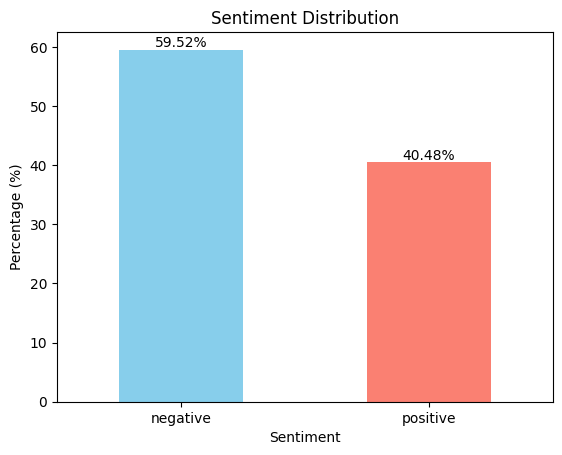

In [ ]:
# Sentiment Distribution with Percentages
sentiment_counts = merged_df['predicted_sentiment'].value_counts()
sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100  # Calculate percentages

# Plotting
sentiment_percentages.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

# Annotating the percentages on the bars
for index, value in enumerate(sentiment_percentages):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

plt.show()

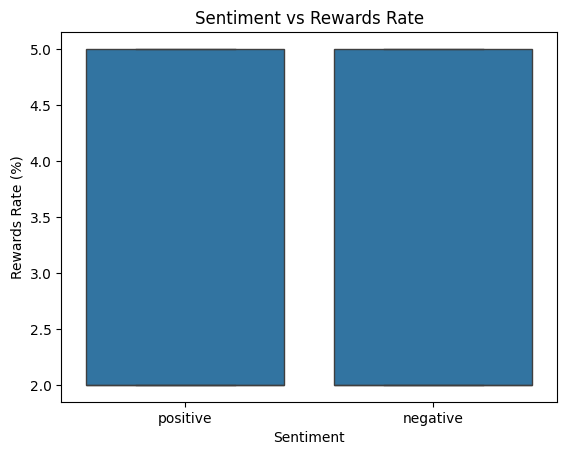

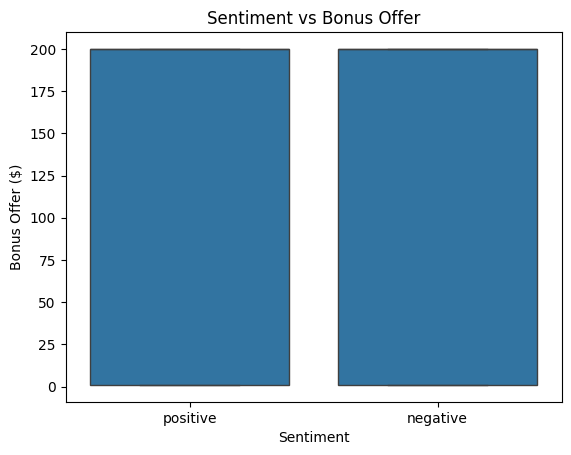

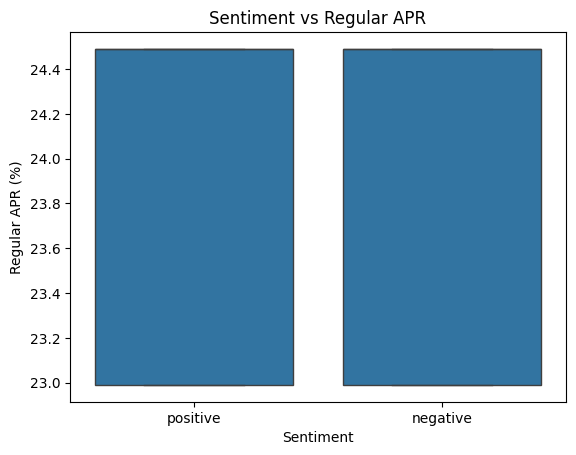

In [ ]:
# Sentiment vs Rewards Rate
sns.boxplot(x='predicted_sentiment', y='Rewards Rate', data=merged_df)
plt.title('Sentiment vs Rewards Rate')
plt.xlabel('Sentiment')
plt.ylabel('Rewards Rate (%)')
plt.show()

# Sentiment vs Bonus Offer
sns.boxplot(x='predicted_sentiment', y='Bonus Offer', data=merged_df)
plt.title('Sentiment vs Bonus Offer')
plt.xlabel('Sentiment')
plt.ylabel('Bonus Offer ($)')
plt.show()

# Sentiment vs Regular APR
sns.boxplot(x='predicted_sentiment', y='Regular APR', data=merged_df)
plt.title('Sentiment vs Regular APR')
plt.xlabel('Sentiment')
plt.ylabel('Regular APR (%)')
plt.show()

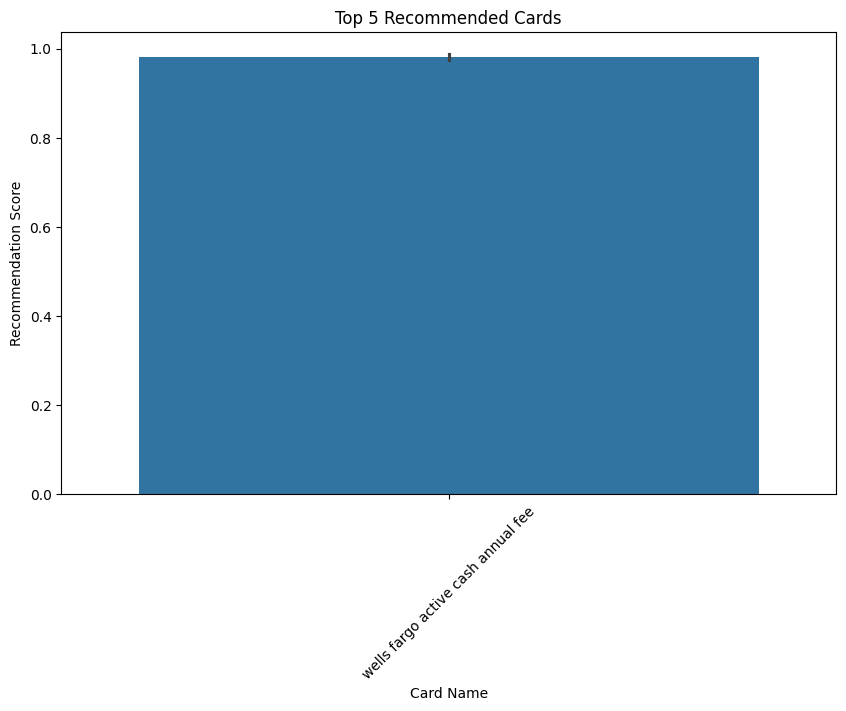

In [ ]:
# Visualize Top Recommendations
plt.figure(figsize=(10, 6))
sns.barplot(x='card_name', y='recommendation_score', data=top_recommendations)
plt.title('Top 5 Recommended Cards')
plt.xticks(rotation=45)
plt.xlabel('Card Name')
plt.ylabel('Recommendation Score')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# TF-IDF vectorization of reviews
tfidf = TfidfVectorizer(max_features=100)  # Adjust max_features as needed
review_features = tfidf.fit_transform(merged_df['review'])

# Combine numeric features with TF-IDF features
numeric_features = merged_df[['Rewards Rate', 'Bonus Offer', 'Regular APR', 'review_length']].fillna(0)
X_combined = hstack([review_features, numeric_features])

# Update the target
y = merged_df['sentiment_numeric']

# Check combined feature set
print("Combined feature set dimensions:", X_combined.shape)

Combined feature set dimensions: (42, 104)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Train-test split with combined features
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import classification_report
y_pred = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.60      0.75         5

    accuracy                           0.78         9
   macro avg       0.83      0.80      0.78         9
weighted avg       0.85      0.78      0.77         9



In [ ]:
# Generate recommendation scores
merged_df['recommendation_score'] = rf_model.predict_proba(X_combined)[:, 1]

# Display top recommended cards
top_recommendations = merged_df.nlargest(5, 'recommendation_score')
print("Top Recommended Cards:")
display(top_recommendations[['card_name', 'Rewards Rate', 'Bonus Offer', 'Regular APR', 'review_length', 'recommendation_score']])

Top Recommended Cards:


,card_name,Rewards Rate,Bonus Offer,Regular APR,review_length,recommendation_score
7,wells fargo active cash annual fee,2.0,200.0,24.49,1323,0.91
34,wells fargo active cash annual fee,2.0,200.0,24.49,1323,0.91
0,wells fargo active cash annual fee,2.0,200.0,24.49,4093,0.90
27,wells fargo active cash annual fee,2.0,200.0,24.49,4093,0.90
6,wells fargo active cash annual fee,2.0,200.0,24.49,297,0.87


from matplotlib import pyplot as plt
_df_0['review_length'].plot(kind='hist', bins=20, title='review_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['recommendation_score'].plot(kind='hist', bins=20, title='recommendation_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='review_length', y='recommendation_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rewards Rate']
  ys = series['review_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Rewards Rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rewards Rate')
_ = plt.ylabel('review_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rewards Rate']
  ys = series['recommendation_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Rewards Rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rewards Rate')
_ = plt.ylabel('recommendation_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Rewards Rate']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Rewards Rate'}, axis=1)
              .sort_values('Rewards Rate', ascending=True))
  xs = counted['Rewards Rate']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Rewards Rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rewards Rate')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Bonus Offer']
  ys = series['review_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Bonus Offer', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Bonus Offer')
_ = plt.ylabel('review_length')

from matplotlib import pyplot as plt
_df_7['review_length'].plot(kind='line', figsize=(8, 4), title='review_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['recommendation_score'].plot(kind='line', figsize=(8, 4), title='recommendation_score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10['review_length'].plot(kind='hist', bins=20, title='review_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11['recommendation_score'].plot(kind='hist', bins=20, title='recommendation_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12.plot(kind='scatter', x='index', y='review_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13.plot(kind='scatter', x='review_length', y='recommendation_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rewards Rate']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('Rewards Rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rewards Rate')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rewards Rate']
  ys = series['review_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('Rewards Rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rewards Rate')
_ = plt.ylabel('review_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Rewards Rate']
  ys = series['recommendation_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_16.sort_values('Rewards Rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rewards Rate')
_ = plt.ylabel('recommendation_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Rewards Rate']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Rewards Rate'}, axis=1)
              .sort_values('Rewards Rate', ascending=True))
  xs = counted['Rewards Rate']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_17.sort_values('Rewards Rate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Rewards Rate')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_18['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['review_length'].plot(kind='line', figsize=(8, 4), title='review_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_20['recommendation_score'].plot(kind='line', figsize=(8, 4), title='recommendation_score')
plt.gca().spines[['top', 'right']].set_visible(False)

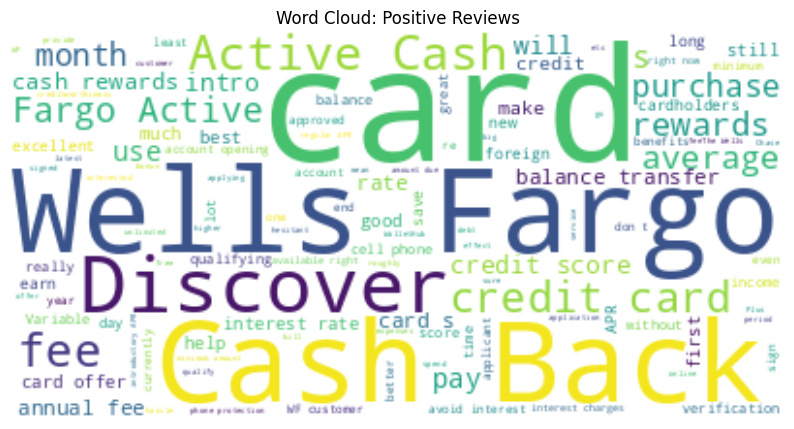

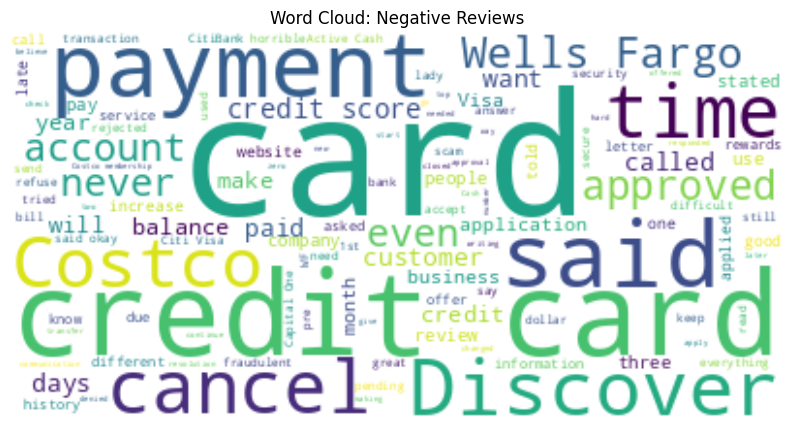

In [ ]:
from wordcloud import WordCloud

# Generate word clouds for positive and negative reviews
positive_reviews = " ".join(merged_df[merged_df['predicted_sentiment'] == 'positive']['review'])
negative_reviews = " ".join(merged_df[merged_df['predicted_sentiment'] == 'negative']['review'])

# Positive reviews word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(background_color='white').generate(positive_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Positive Reviews')
plt.show()

# Negative reviews word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(background_color='white').generate(negative_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Negative Reviews')
plt.show()

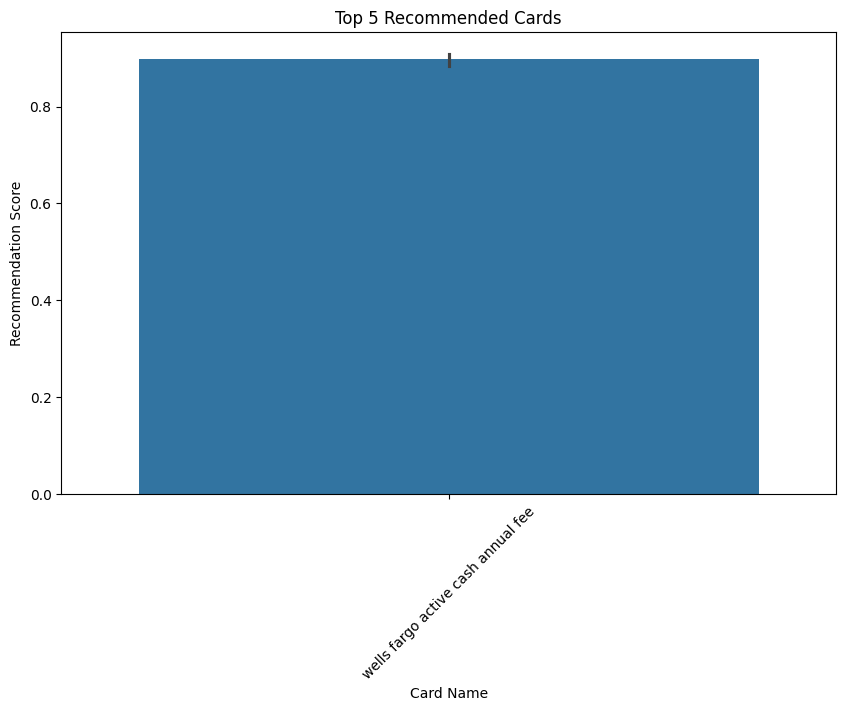

In [ ]:
# Visualize top recommendations
plt.figure(figsize=(10, 6))
sns.barplot(x='card_name', y='recommendation_score', data=top_recommendations)
plt.title('Top 5 Recommended Cards')
plt.xticks(rotation=45)
plt.xlabel('Card Name')
plt.ylabel('Recommendation Score')
plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

In [ ]:
X = merged_df['review']

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Only top 1000 important features
X_tfidf = tfidf_vectorizer.fit_transform(X)  # Transform text to numerical features

In [ ]:
y = merged_df['predicted_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)  # Convert to binary (1 for positive, 0 for negative)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
merged_df['predicted_sentiment_score'] = rf_model.predict_proba(X_tfidf)[:, 1]  # Get probability for positive clas

In [ ]:
top_cards_rf = merged_df.sort_values(by='predicted_sentiment_score', ascending=False).head(5)

In [ ]:
top_cards_rf_display = top_cards_rf[['card_name', 'predicted_sentiment_score', 'review']]

In [ ]:
print(top_cards_rf_display)

                             card_name  predicted_sentiment_score  \
34  wells fargo active cash annual fee                       0.89   
7   wells fargo active cash annual fee                       0.89   
0   wells fargo active cash annual fee                       0.78   
27  wells fargo active cash annual fee                       0.78   
13  wells fargo active cash annual fee                       0.75   

                                               review  
34  I have been a Wells Fargo customer for over 15...  
7   I have been a Wells Fargo customer for over 15...  
0   The Wells Fargo Active Cash® Card is one of th...  
27  The Wells Fargo Active Cash® Card is one of th...  
13  Excellent card for everyday use. Hard to beat ...  


In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.50      0.67         8

    accuracy                           0.69        13
   macro avg       0.78      0.75      0.69        13
weighted avg       0.83      0.69      0.68        13



In [ ]:
importances = rf_model.feature_importances_
features = tfidf_vectorizer.get_feature_names_out()

In [ ]:
indices = np.argsort(importances)[::-1]  # Sort features by importance

# Display top 10 most important words for the model
print("Top 10 important features:")
for i in range(10):
    print(f"{features[indices[i]]}: {importances[indices[i]]:.4f}")

Top 10 important features:
rewards: 0.0326
did: 0.0275
available: 0.0252
unlimited: 0.0242
wells: 0.0228
solid: 0.0200
fargo: 0.0197
long: 0.0187
limit: 0.0177
overall: 0.0163


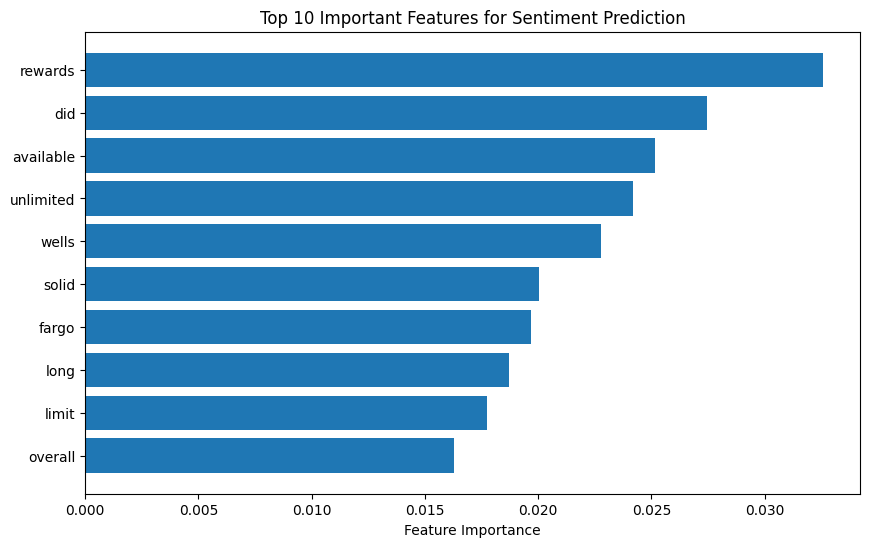

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature importance from the trained Random Forest model
importances = rf_model.feature_importances_
features = tfidf_vectorizer.get_feature_names_out()

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices[:10]], align='center')
plt.yticks(range(10), [features[i] for i in indices[:10]])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for Sentiment Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at the top
plt.show()

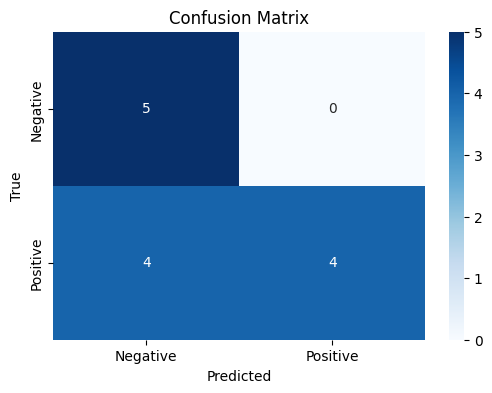

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

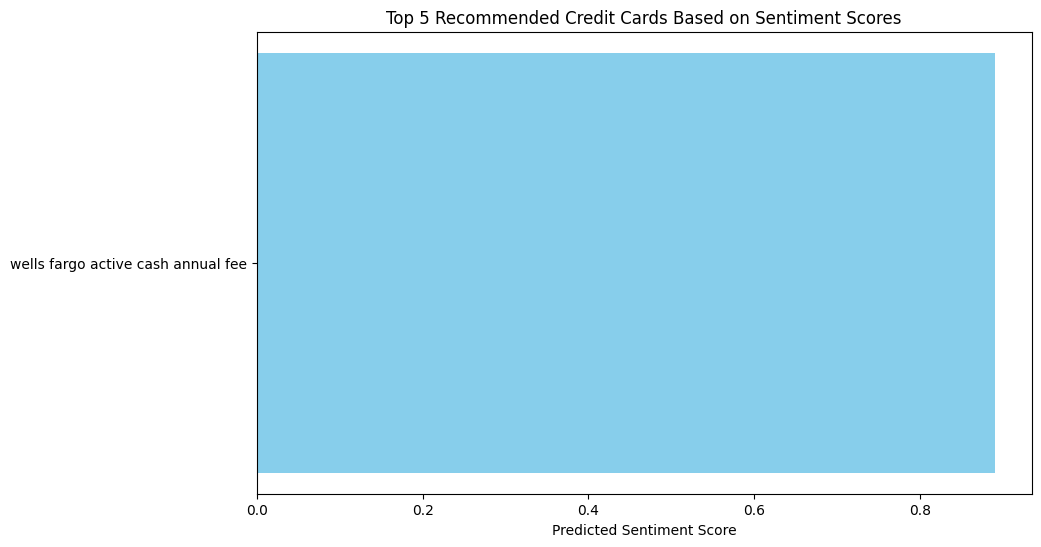

In [ ]:
# Assuming we have the 'predicted_sentiment_score' column in merged_df after training the model
top_cards_rf = merged_df.sort_values(by='predicted_sentiment_score', ascending=False).head(5)

# Plotting the top 5 cards based on predicted sentiment scores
plt.figure(figsize=(10, 6))
plt.barh(top_cards_rf['card_name'], top_cards_rf['predicted_sentiment_score'], color='skyblue')
plt.xlabel('Predicted Sentiment Score')
plt.title('Top 5 Recommended Credit Cards Based on Sentiment Scores')
plt.show()

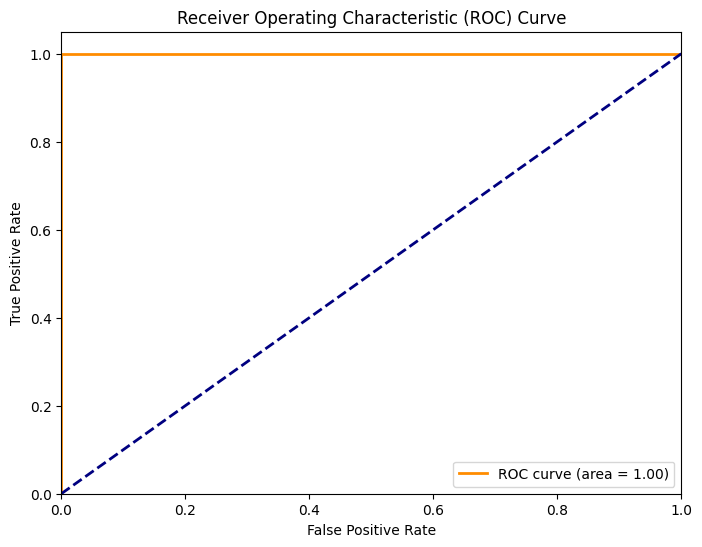

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Step 1: Sort the dataframe by recommendation_score in descending order
top_cards = merged_df.sort_values(by='recommendation_score', ascending=False).head(5)

# Step 2: Display relevant information for the top 5 recommended cards
top_cards_display = top_cards[['card_name', 'recommendation_score', 'review']]

# Display the top 5 recommended cards
print(top_cards_display)

                             card_name  recommendation_score  \
7   wells fargo active cash annual fee                  0.91   
34  wells fargo active cash annual fee                  0.91   
0   wells fargo active cash annual fee                  0.90   
27  wells fargo active cash annual fee                  0.90   
6   wells fargo active cash annual fee                  0.87   

                                               review  
7   I have been a Wells Fargo customer for over 15...  
34  I have been a Wells Fargo customer for over 15...  
0   The Wells Fargo Active Cash® Card is one of th...  
27  The Wells Fargo Active Cash® Card is one of th...  
6   I have a credit score of 817, substantial asse...  
